In [2]:
import os
import pickle
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt

from openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [3]:
class DataPlotter(object):
    
    def __init__(self, d_labels_to_info):
        
        # Set unsampled state indices
        self.first_unsampled_state_index = 0
        self.last_unsampled_state_index = -1
        
        # Load complex free energy data
        data = OrderedDict()
        for i, (label, d_info) in enumerate(d_labels_to_info.items()):
            
            if "apo" not in label:
                
                # Load complex free energy matrices at each time point
                file_paths = d_info["file_paths"]
                slice_begs = d_info["slice_begs"]
                slice_ends = d_info["slice_ends"]
                total_iterations = d_info["total_iterations"]
                
                for j, (file_path, slice_beg, slice_end) in enumerate(zip(file_paths, slice_begs, slice_ends)):

                    if j == 0:
                        with open(file_path, "rb") as f:
                            results = pickle.load(f)
                        data[label] = {"results_complex": results[slice_beg:slice_end]}

                    else:
                        with open(file_path, "rb") as f:
                            results = pickle.load(f)
                        data[label]["results_complex"] += results[slice_beg:slice_end]

                data[label]["total_iterations"] = total_iterations
            
            else:
                
                # Load apo free energy data (10 ns/replica AREX)
                file_path_apo = d_info["file_paths"][0]
                with open(file_path_apo, "rb") as f:
                    results = pickle.load(f)
                data["results_apo"] = results
            
        # Experiment
        filepath_parts = file_path.split("/")
        sub_dir = int(filepath_parts[-3])
        experiment = [-0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1, 0.1, -3.4, -1.6, -1.8, 0, -1.4, -0.5, -4.5, -7.7, -5.4, -5.2, -5.4, -5.5, -6.1]
        data["experiment"] = experiment[sub_dir]
        
        self.data = data
        
        # Set colors
        self.colors = ["#80b1d3", "#fdb462", "#b3de69"]
        
    def _generate_free_energy_timeseries_plot(self, 
                                              show_legend=False, 
                                              y_axis_min=None, 
                                              y_axis_max=None, 
                                              legend_ncol=2,
                                              skip_replicate_label=False, 
                                              skip_replicate_linestyles=False,
                                              figsize=None,
                                              save_path=None):
        
        # Set default for y_axis_mean
        y_axis_mean = -1e6
    
        # Set figure size
        if not figsize:
            figsize = (8, 4)
        fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=figsize)
        
        # Assemble data
        dgs_all = {} # key : replicate, value: complex free energy timeseries
        ddgs_all = {} # key : replicate, value: complex uncertainty timeseries
        labels = [] # label for each simulation type
        for i, (label, data) in enumerate(self.data.items()):
            if label not in ["results_apo", "experiment"]: 
                
                # Get total ns
                total_ns = int(data["total_iterations"] / 1000)
                
                # Retrieve label
                title = label.split("(")[0][:-1]
                mutation = title.split(" ")[0]
                experiment_label = label.split("(")[-1][:-1]
                replicate = experiment_label[-1]
                simulation_type = experiment_label[:-3]
                if simulation_type not in labels:
                    labels.append(simulation_type)

                # Retrieve x values (time points)
                x = np.array(range(1000, data["total_iterations"] + 1, 1000)) / 1000

                # Retrieve complex free energies in kcal/mol
                dgs = np.array([t["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results_complex"]])
                ddgs = np.array([t["dDeltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results_complex"]])

                # Store the complex free energy timeseries 
                if replicate not in dgs_all:
                    dgs_all[replicate] = {simulation_type: dgs}
                    ddgs_all[replicate] = {simulation_type: ddgs}
                else:
                    dgs_all[replicate][simulation_type] = dgs
                    ddgs_all[replicate][simulation_type] = ddgs

        # Assemble apo free energies
        apo_dg = self.data["results_apo"]["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL
        apo_ddg = self.data["results_apo"]["dDeltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL

        # Set font size
        plt.rc('font', size=15) 
        
        # Plot
        linestyles = ["solid", "dotted", "dashed"]
        for replicate in dgs_all:
            for label, dgs in dgs_all[replicate].items():

                complex_dgs = dgs
                print(complex_dgs)
                complex_ddgs = ddgs_all[replicate][label]
                experiment = self.data["experiment"]
                y = (complex_dgs - apo_dg) - experiment
                yerr = ((apo_ddg**2 + complex_ddgs**2)**0.5)

                label_final = f"{label}" if skip_replicate_label else f"{label} r{replicate}"
                linestyle = "solid" if skip_replicate_linestyles else linestyles[int(replicate)]
                axes.plot(x, y, label=label_final, color=self.colors[labels.index(label)], linestyle=linestyle)
                axes.fill_between(x, y - (2 * yerr), y + (2 * yerr), color=self.colors[labels.index(label)], alpha=0.5)

                # Determine y axis mean
                y_mean = np.mean(y)
                if y_mean > y_axis_mean:
                    y_axis_mean = y_mean
            
        # Plot zero bias
        axes.axhline(y=0, linestyle='dotted', linewidth=2, color='gray')
        
        # Handle legend
        if show_legend:
            axes.legend(ncol=legend_ncol)
        
        # Set x and y axis labels
        y_label = r"$\Delta\Delta G$ discrepancy (kcal/mol)"
        axes.set_ylabel(y_label)
        axes.set_xlabel("t (ns)")
        
        # Set x and y limits
        if not y_axis_min:
            y_axis_min = round(y_axis_mean) - 4
        if not y_axis_max:
            y_axis_max = round(y_axis_mean) + 8
        plt.yticks(np.arange(y_axis_min, y_axis_max, 2.0))
        if total_ns == 10:
            plt.xticks(np.arange(1, total_ns + 1, 1.0))
        else:
            plt.xticks([1] +  list(np.arange(10, total_ns + 1, 10.0)))
        
        # Set title
        axes.set_title(mutation)
        
        # Ensure x-axis labels are not cut off
        plt.tight_layout()

        # Save plot as pdf
        if save_path:
            plt.savefig(save_path, dpi=500)
            plt.show()
            plt.clf()
        else:
            plt.show()
        


# Barnase:barstar

## With and without rest (0.5 nm 600 K)

### Complex 50 ns

[-28.98003638 -29.60274969 -30.17589097 -30.69322985 -31.09090856
 -31.39080318 -31.58976273 -31.73922857 -31.80268329 -31.94320631
 -32.06381697 -32.1706233  -32.28300667 -32.34944169 -32.39096879
 -32.47733366 -32.54057505 -32.59183742 -32.68037755 -32.72299246
 -32.84815156 -32.94473038 -32.99076466 -33.02582546 -33.04443186
 -33.05404143 -33.04222052 -33.03046445 -33.01704049 -33.00441419
 -32.98396042 -32.98215562 -32.99535961 -33.00398819 -33.02196205
 -33.01132019 -33.02203302 -33.04468868 -33.05573514 -33.08731799
 -33.11260832 -33.12850777 -33.14425091 -33.17567338 -33.18209757
 -33.17755068 -33.20676094 -33.23844546 -33.25716054 -33.27102482]
[-32.28049856 -32.88439005 -32.69475836 -32.75749487 -32.80040598
 -32.84395968 -32.8970587  -32.98571524 -33.06201216 -33.13757762
 -33.1785317  -33.31118846 -33.28099713 -33.26700339 -33.22697945
 -33.17209937 -33.1169044  -33.04435442 -32.99726174 -33.00609066
 -32.9674603  -33.00423928 -33.05783084 -33.08447606 -33.0683181
 -33.10432

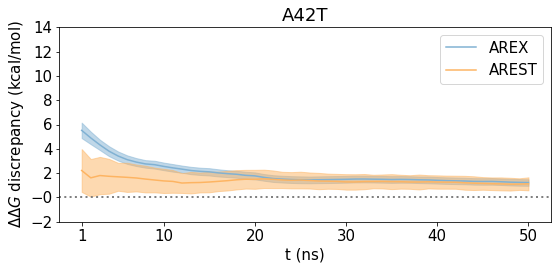

<Figure size 432x288 with 0 Axes>

In [7]:
# A42T
main_dir = 45
main_dir_rest = 52
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"

sub_dir = "9"
sub_dir_rest = "17"
d_labels_to_info = OrderedDict({
                    "A42T apo (AREX r0)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                              },
                    "A42T complex (AREX r1)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              },
                    "A42T complex (AREST r0)": {"file_paths": 
                                                    [os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                "slice_begs": [0],
                                                "slice_ends": [50],
                                                "total_iterations": 50000,
                                              },
                    })

save_path = os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{sub_dir_rest}_{phase}_series_50ns.pdf")
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_timeseries_plot(show_legend=True, y_axis_min=-2.01, y_axis_max=14, legend_ncol=1, skip_replicate_label=True, skip_replicate_linestyles=True, save_path=save_path)



[115.37925243 114.38997625 113.59907921 112.88209231 112.57279225
 112.14460891 111.81093411 111.25784827 110.82270806 110.41641139
 110.17110461 110.02973982 109.81861861 109.61442179 109.46503027
 109.27850318 109.09629584 108.91853755 108.72731146 108.58846174
 108.46357832 108.30432027 108.14127184 108.02644462 107.91417257
 107.77902082 107.66387754 107.60578951 107.52406059 107.44684283
 107.34989992 107.25947029 107.16879519 107.07101785 106.98506342
 106.90226048 106.83259649 106.80897573 106.73141043 106.65552939
 106.57614913 106.5156462  106.46701584 106.40711701 106.36544892
 106.33112347 106.29919771 106.28262987 106.24471837 106.20127427]
[112.55026643 110.54894027 109.80538539 109.21252457 108.5831784
 108.15083955 107.63440894 107.41465287 107.32879268 107.18979225
 107.03769592 106.99041872 107.1404102  107.21374695 107.20402195
 107.10575897 107.00608201 106.93009858 106.80964305 106.72735632
 106.72407052 106.76177179 106.80685001 106.82775949 106.92440035
 106.94272

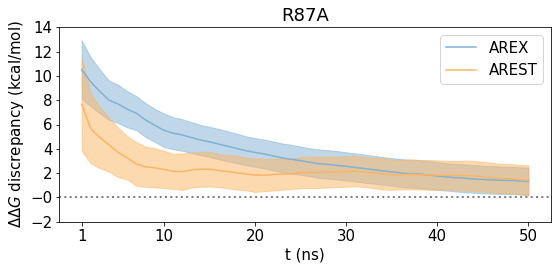

<Figure size 432x288 with 0 Axes>

In [8]:
main_dir = 45
main_dir_rest = 52
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"

sub_dir = "10"
sub_dir_rest = "12"
d_labels_to_info = OrderedDict({
                    "R87A apo (AREX r0)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                              },
                    "R87A complex (AREX r1)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              },
                    "R87A complex (AREST r0)": {"file_paths": 
                                                    [os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                "slice_begs": [0],
                                                "slice_ends": [50],
                                                "total_iterations": 50000,
                                              },
                    })

save_path = os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{sub_dir_rest}_{phase}_series_50ns.pdf")
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_timeseries_plot(show_legend=True, y_axis_min=-2.01, y_axis_max=14, legend_ncol=1, skip_replicate_label=True, skip_replicate_linestyles=True, save_path=save_path)



[-162.94703981 -165.144844   -165.81038167 -166.28923091 -166.56368084
 -166.62516397 -166.73262125 -166.88156758 -166.98947836 -167.08001991
 -167.01122419 -166.90182323 -166.78700488 -166.69582806 -166.67669566
 -166.63570651 -166.52494873 -166.47124795 -166.44232497 -166.44066686
 -166.39811548 -166.34080321 -166.29161765 -166.26766953 -166.24240598
 -166.21273159 -166.17573614 -166.14726566 -166.13118172 -166.17348563
 -166.2124667  -166.21017345 -166.20925281 -166.18496729 -166.18994888
 -166.2076482  -166.23868905 -166.2519144  -166.28022975 -166.28135358
 -166.28834453 -166.29730957 -166.29136848 -166.29713873 -166.31571506
 -166.34172266 -166.36665466 -166.40834104 -166.44923819 -166.47692944]
[-164.87000412 -165.32516021 -165.65321801 -166.31649293 -166.46773014
 -166.53179681 -166.523066   -166.58141094 -166.75855608 -166.87387347
 -166.87088362 -166.8941957  -166.96254648 -166.93175449 -166.86167742
 -166.87868195 -166.89328581 -166.89327776 -166.88704835 -166.95283872
 -167

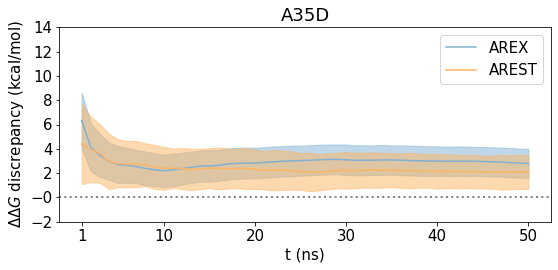

[-261.45013868 -264.45111672 -265.76531507 -266.76824422 -267.33939941
 -267.70502309 -267.95890491 -268.13249113 -268.159284   -268.31308553
 -268.42083733 -268.53410904 -268.57639478 -268.67468785 -268.77224925
 -268.8275171  -268.85816243 -268.91625688 -268.92680775 -268.96978035
 -268.99613696 -269.02755473 -269.06586649 -269.095475   -269.11205418
 -269.14114709 -269.1853259  -269.23159436 -269.28360965 -269.35255862
 -269.43941244 -269.46757804 -269.47092274 -269.51576849 -269.54849466
 -269.57856258 -269.57174016 -269.54043943 -269.55236112 -269.56367318
 -269.58498971 -269.58787259 -269.59464401 -269.5956968  -269.58555043
 -269.59405551 -269.5953312  -269.6186361  -269.60658376 -269.59853026]
[-264.28234269 -265.94244865 -267.35156435 -267.98662716 -268.21885727
 -268.64855308 -268.63960481 -268.66534558 -268.77599607 -268.75290271
 -268.82180814 -268.75314724 -268.96887421 -269.11861289 -269.17524107
 -269.08513408 -269.14527832 -269.28935327 -269.39752755 -269.42859994
 -269

<Figure size 432x288 with 0 Axes>

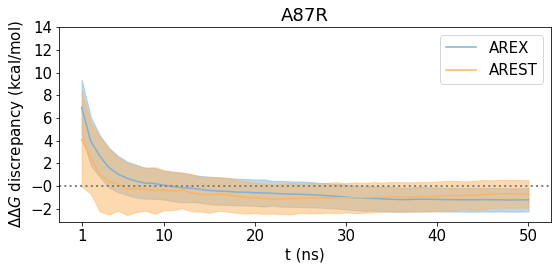

[31.44013144 31.31710909 31.08625862 30.98102619 30.87319161 30.79613539
 30.7236158  30.60135736 30.48126365 30.27160219 30.14069295 30.06172593
 29.97561384 29.87000776 29.79982561 29.77361504 29.74601511 29.67427699
 29.60100052 29.55136877 29.51036118 29.46381795 29.42884773 29.39928908
 29.35240295 29.30660979 29.26813977 29.24559763 29.19795312 29.15455687
 29.10136961 29.05679808 29.01256857 28.99900338 28.96819253 28.92480258
 28.88547627 28.85963186 28.84982681 28.82450201 28.78623879 28.7687624
 28.75290317 28.74206596 28.72299169 28.69398356 28.66340534 28.6315681
 28.59845831 28.56881761]
[31.16314083 30.82823666 30.37749224 30.22611707 30.03753649 29.90214576
 29.71983226 29.54397387 29.53968146 29.60582785 29.44888515 29.40778152
 29.34024001 29.23999585 29.13707435 29.20335163 29.24667664 29.21882892
 29.18750917 29.12083768 29.05837296 28.98439722 28.94860722 28.97276518
 29.02932824 29.05415222 29.01056033 28.99374083 28.95631736 28.92760307
 28.86085351 28.83836283 28

<Figure size 432x288 with 0 Axes>

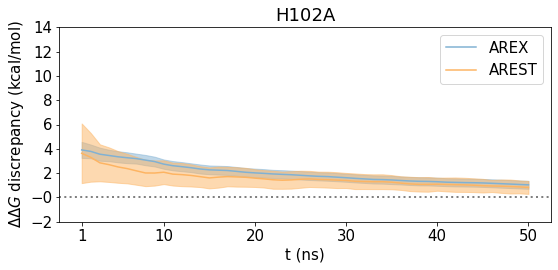

[-165.51500794 -167.54231351 -168.11241201 -169.00485065 -169.50555871
 -169.9176567  -170.48948107 -170.71268516 -170.80218049 -170.95440386
 -171.03881153 -171.08458353 -171.08326907 -171.08490593 -171.12391308
 -171.1877369  -171.16351472 -171.13348482 -171.11769958 -171.14901646
 -171.18114487 -171.19104167 -171.17589108 -171.11982929 -171.0902239
 -171.06585934 -171.0711394  -171.04852989 -171.0311806  -171.00166151
 -170.99816765 -171.00450343 -170.98375817 -170.97020942 -170.98259066
 -170.9701366  -170.93782541 -170.90278429 -170.86032357 -170.83219514
 -170.82253752 -170.79298574 -170.75133374 -170.7242898  -170.71018297
 -170.67320452 -170.66056775 -170.65315319 -170.63621456 -170.62905291]
[-167.70998818 -169.6513136  -169.93597655 -170.00264872 -170.01992701
 -170.07846966 -170.22708388 -170.45341596 -170.58446685 -170.76994945
 -170.88298887 -171.01402197 -170.96463151 -170.94173823 -170.86797448
 -170.90996315 -170.84291588 -170.95967833 -170.98134104 -171.00685509
 -170.

<Figure size 432x288 with 0 Axes>

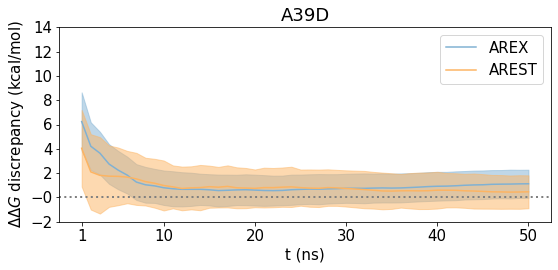

[34.53836557 33.26203928 32.4571517  32.28841718 32.17563173 31.90980345
 31.67047045 31.61019899 31.38513594 31.23348147 31.0340718  30.9648094
 30.86966612 30.73414124 30.56949332 30.52726732 30.50520375 30.43950046
 30.44142    30.40477821 30.40336461 30.32591734 30.26906443 30.21827233
 30.18294606 30.16284826 30.17541481 30.15748391 30.12838544 30.09949886
 30.10785621 30.11090197 30.11679942 30.15650012 30.17295507 30.19010756
 30.14670137 30.11091964 30.08312313 30.05509329 30.04419755 30.02738582
 30.01682014 30.03671135 30.04482847 30.03912638 30.01096234 29.97789175
 29.94601816 29.93212996]
[32.2954447  31.69234314 31.02272585 30.46788313 30.21136729 29.73552082
 29.53006335 29.31596097 29.15014749 29.04780925 28.90845301 28.75597631
 28.6499146  28.63897981 28.56915794 28.46793155 28.50173691 28.51009249
 28.49181913 28.39990312 28.34626769 28.32096694 28.28401874 28.2437971
 28.2476108  28.27887013 28.28291778 28.25252435 28.25654707 28.26918945
 28.23612527 28.24349585 28

<Figure size 432x288 with 0 Axes>

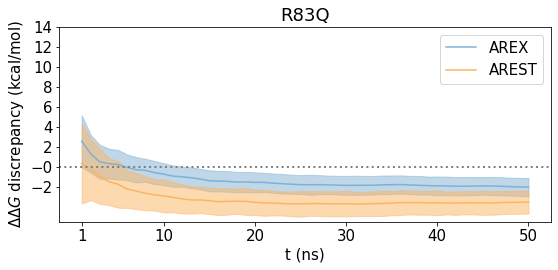

[-176.71702228 -179.90558173 -181.27071217 -182.33700406 -183.43005796
 -184.0636913  -184.68084327 -185.27365371 -185.7188123  -186.01036429
 -186.26933229 -186.55885488 -186.85369979 -186.94082405 -187.09874702
 -187.23177749 -187.30703948 -187.41410415 -187.54103712 -187.63772868
 -187.71030606 -187.78312509 -187.81353833 -187.85075881 -187.86778053
 -187.94286905 -188.06839823 -188.16878755 -188.22208077 -188.30271919
 -188.40693665 -188.45484384 -188.53671762 -188.61802709 -188.70111555
 -188.76415744 -188.8828998  -188.96734157 -189.04663303 -189.11616038
 -189.17130389 -189.22411115 -189.26453471 -189.31700507 -189.39355527
 -189.45664688 -189.51513361 -189.54741219 -189.58066239 -189.634582  ]
[-178.29427444 -181.51421003 -183.46622275 -184.18051347 -184.82787364
 -185.38852085 -185.79106281 -186.08089882 -186.3964993  -186.85332555
 -187.15072644 -187.42855394 -187.66404244 -187.9215033  -188.15585117
 -188.42274349 -188.55789678 -188.64454849 -188.7231524  -188.84538517
 -189

<Figure size 432x288 with 0 Axes>

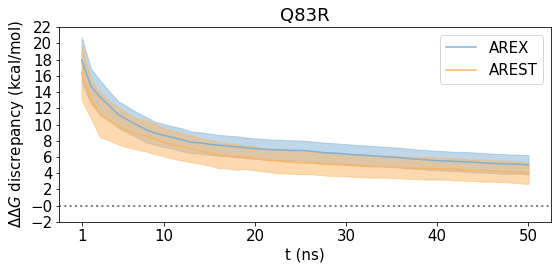

<Figure size 432x288 with 0 Axes>

In [9]:
main_dir_rest = 52
phase = 'complex'

d_mutations = {
               "A35D": {"main_dir": 47, 
                      "sub_dir": "21",
                      "rest_replicate": 1},
    
               "A87R": {"main_dir": 47, 
                      "sub_dir": "26"},
        
               "H102A": {"main_dir": 47,
                        "sub_dir": "13"},
               
               "A39D": {"main_dir": 47,
                         "sub_dir": "22"
                        },
    
               "R83Q": {"main_dir": 47,
                     "sub_dir": "11"
                    },
               
               "Q83R": {"main_dir": 47,
                         "sub_dir": "25"
                        }
            }

for name, info in d_mutations.items():
    
    main_dir = info["main_dir"]
    sub_dir = info["sub_dir"]
    sub_dir_rest = info["sub_dir"]
    rest_replicate = info["rest_replicate"] if "rest_replicate" in info else 0
    
    base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
    base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"

    d_labels_to_info = OrderedDict({
                        f"{name} apo (AREX r1)": {"file_paths": 
                                                       [os.path.join(base_path, sub_dir, f"replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                                  },
                        
                        f"{name} complex (AREX r1)": {"file_paths": 
                                                       [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                   "slice_begs": [0],
                                                   "slice_ends": [50],
                                                   "total_iterations": 50000,
                                                  },

                        f"{name} complex (AREST r{rest_replicate})": {"file_paths": 
                                                        [os.path.join(base_path_rest, sub_dir_rest, f"replicate_{rest_replicate}", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                    "slice_begs": [0],
                                                    "slice_ends": [50],
                                                    "total_iterations": 50000,
                                                  },
                        })

    save_path = os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{sub_dir_rest}_{phase}_series_50ns.pdf")
    data_plotter = DataPlotter(d_labels_to_info)
    y_axis_min = -2.01
    y_axis_max = 22 if name == "Q83R" else 14
    data_plotter._generate_free_energy_timeseries_plot(show_legend=True, y_axis_min=y_axis_min, y_axis_max=y_axis_max, legend_ncol=1, skip_replicate_label=True, skip_replicate_linestyles=True, save_path=save_path)

